# Introduction

This notebook describes the statistical models and Python functionality that are implemented in this module, and then illustrates their use with a series of examples.

# Statistical Methods

Suppose that $M$ models provide predictive distributions for the outcome variable $Y_{i}$ for forecast tasks indexed by $i \in \mathcal{I}$. For instance, a forecast task may correspond to a particular combination of location, forecast date, and forecast horizon. We assume that the values of the predictive density (PDF) $\widehat{f}_{m}(y_i)$ and predictive distribution function (CDF) $\widehat{F}_{m}(y_i)$ are available for observations $i = 1, \ldots, N$ in a training set and models indexed by $m = 1, \ldots, M$, although missing values are allowed, and will be handled by rescaling the model weights as described below.

We construct a CDF-recalibrated linear pool that obtains the predictive CDF for an ensemble forecaster as
$$F_{\text{ens},i}(y) = G\left(\sum_{m=1}^M \pi_m F_{m,i}(y); \theta \right).$$
Here the weights $\pi_m$ are constrained to be non-negative and sum to 1. In case the forecasts for one or more models are missing for task $i$, the corresponding model weights are set to zero and the weights for the remaining models are rescaled proportionately to sum to 1. $G$ denotes the CDF of a re-calibrating distribution with parameters $\theta$ that has support on the interval $[0, 1]$. By the chain rule, the PDF of the ensemble forecaster is
$$f_{\text{ens},i}(y) = g\left(\sum_{m=1}^M \pi_m F_{m,i}(y); \theta \right) \sum_{m=1}^M \pi_m f_{m,i}(y).$$

We consider two options for the distribution $G$:
1. The Uniform(0, 1) distribution, in which case $g(\cdot) = 1$ and the ensemble forecast reduces to a linear pool. Here the recalibration distribution does not have any parameters $\theta$.
2. A mixture of beta distributions with
$G(p) = \sum_{k = 1}^K \omega_k B(p ; \alpha_k, \beta_k),$
where $K$ is the number of mixture components, the weights $\omega_k$ are non-negative and sum to 1, and $B$ denotes the cdf of a beta distribution with shape parameters $\alpha$ and $\beta$. Here $\theta = \{\omega_1, \alpha_1, \beta_1 \ldots, \omega_K, \alpha_K, \beta_K \}$.

The linear pool model weights $\pi$ and the parameters of the recalibration function $\theta$ are estimated simultaneously by optimizing the log score of the ensemble forecasts over the training set.

# Overview of module API

This module provides two classes that users will interact with: `LinearPool` and `BetaMixtureRCLP`. These are subclasses of `BaseRCLP`, which implements routines for estimation and calculating ensemble distribution values. The `init` method of `LinearPool` takes only one argument: `M`, the number of component models; the `init` method of `BetaMixtureRCLP` takes the argument `M` and `K`, the number of beta mixture components.

Objects of both classes have the following methods and properties that users will typically interact with:
 * `parameters` is a dictionary of parameters, which are intialized randomly at the time of object instantiation
 * `fit` estimates the ensemble parameters $\pi$ and $\theta$
 * `loss_trace` contains the value of the loss function after each optimization iteration
 * `log_prob` and `prob` calculate the (log) PDF of the ensemble distribution at a vector of observed values `y`
 * `log_cdf` and `cdf` calculate the (log) CDF of the ensemble distribution at a vector of observed values `y`

# Examples

We illustrate the package's functionality with four examples.


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from rclp.rclp import LinearPool, BetaMixtureRCLP

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from numpy.random import default_rng
from scipy.stats import norm

## Example 1: recovering the parameters of a mixture distribution

We generate data from a mixture of three normal distributions and then estimate the mixture weights using a `LinearPool`, assuming the component distributions are known. The data are generated from the following model:

\begin{align*}
F(y) &= 0.1 F_1(y; \mu = -1, \sigma = 1) + 0.6 F_2(y; \mu = 0, \sigma = 0.5) + 0.3 F_3(y; \mu = 2, \sigma = 2),
\end{align*}

where $F_k, \, k = 1, \ldots, 3$ denote the CDFs of normal distributions with the specified mean and standard deviation. The goal is to recover the component model weights $\pi = [0.1, 0.6, 0.3]$ given a set of $N=1000$ observations from this distribution.


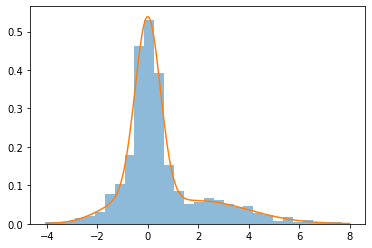

In [2]:
# simulate data from a mixture of normal distributions
# mixture parameters
w = [0.1, 0.6, 0.3]
mu = np.array([-1.0, 0.0, 2.0])
sigma = np.array([1.0, 0.5, 2.0])

# sample size
n = 1000

# init rng
rng = default_rng(42)

# mixture component indicator
z = np.argmax(rng.multinomial(n=1, pvals=w, size=n), axis=1)

# sampled values of outcome variable
y = rng.standard_normal(n) * sigma[z] + mu[z]

# make a plot with histogram of sampled values and exact density of the mixture
y_grid = np.linspace(start=-4.0, stop=8.0, num=201)
f = w[0] * norm.pdf(y_grid, loc=mu[0], scale=sigma[0]) + \
    w[1] * norm.pdf(y_grid, loc=mu[1], scale=sigma[1]) + \
    w[2] * norm.pdf(y_grid, loc=mu[2], scale=sigma[2])
plt.hist(y, bins=30, density=True, histtype='stepfilled', alpha=0.5)
plt.plot(y_grid, f)
plt.show()

In [3]:
# fit a weighted linear pool to attempt to recover the mixture weights,
# assuming the component distributions are known

# first, calculate the log pdf and cdf values of each y from the component distributions
# arranged in arrays of shape (1000, 3)
component_log_prob = np.stack(
    [norm.logpdf(y, loc=mu[i], scale=sigma[i]) for i in range(3)],
    axis=1)
component_log_cdf = np.stack(
    [norm.logcdf(y, loc=mu[i], scale=sigma[i]) for i in range(3)],
    axis=1)

# define a linear pool object for 3 component models and fit it
lp = LinearPool(M=3)
lp.fit(component_log_prob=component_log_prob, component_log_cdf=component_log_cdf,
       optim_method="adam", num_iter=100, learning_rate=0.1)

# look at the fitted parameter values -- compare to the true values of [0.1, 0.6, 0.3]
lp.parameters

2022-09-24 20:35:37.305223: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


{'lp_w': <TransformedVariable: name=lp_w, dtype=float32, shape=[3], fn="softmax_centered", numpy=array([0.10806113, 0.5887431 , 0.30319577], dtype=float32)>}

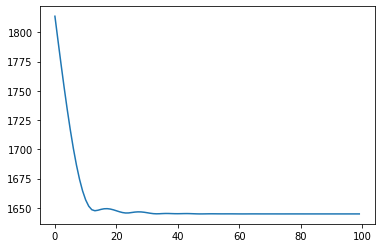

In [4]:
# plot loss trace
# if optimization was successful, this should have stabilized around a low value
plt.plot(lp.loss_trace)

## Example 2: component forecasters are misspecified

In this example, we illustrate the methods in a setting where the component forecasters are misspecified. We generate data from the following model:

\begin{align*}
F(y) &= 0.2 F_1(y; \mu = -2, \sigma = 0.5) + 0.5 F_2(y; \mu = 0, \sigma = 0.5) + 0.3 F_3(y; \mu = 2, \sigma = 2),
\end{align*}

However, we fit an ensemble that includes only two component models: a $\text{Normal}(\mu = -1, \sigma = 1)$ distribution and a $\text{Normal}(1, 1)$ distribution. We compare three ensemble specifications:
 1. a `LinearPool`
 2. a `BetaMixtureRCLP` with $K=1$ beta component
 3. a `BetaMixtureRCLP` with $K=10$ beta components

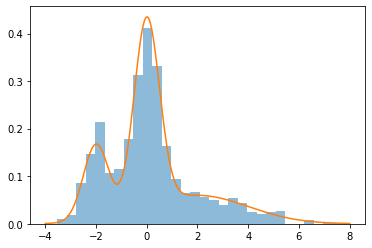

In [5]:
# simulate data from a mixture of normal distributions
# mixture parameters
w = [0.2, 0.5, 0.3]
mu = np.array([-2.0, 0.0, 2.0])
sigma = np.array([0.5, 0.5, 2.0])

# sample size
n = 1000

# init rng
rng = default_rng(42)

# mixture component indicator; there is probably a better way?
z = np.argmax(rng.multinomial(n=1, pvals=w, size=n), axis=1)

# sampled values of outcome variable
y = rng.standard_normal(n) * sigma[z] + mu[z]

# make a plot with histogram of sampled values and exact density of the mixture
y_grid = np.linspace(start=-4.0, stop=8.0, num=201)
f = w[0] * norm.pdf(y_grid, loc=mu[0], scale=sigma[0]) + \
    w[1] * norm.pdf(y_grid, loc=mu[1], scale=sigma[1]) + \
    w[2] * norm.pdf(y_grid, loc=mu[2], scale=sigma[2])
F = w[0] * norm.cdf(y_grid, loc=mu[0], scale=sigma[0]) + \
    w[1] * norm.cdf(y_grid, loc=mu[1], scale=sigma[1]) + \
    w[2] * norm.cdf(y_grid, loc=mu[2], scale=sigma[2])
plt.hist(y, bins=30, density=True, histtype='stepfilled', alpha=0.5)
plt.plot(y_grid, f)
plt.show()

In [6]:
# fit a weighted linear pool,
# assuming the component distributions are known but misspecified

# component parameters
component_mu = np.array([-1.0, 1.0])
component_sigma = np.array([1.0, 1.0])

# calculate the log pdf and cdf values of each y from the component distributions
# arranged in arrays of shape (1000, 2)
component_log_prob = np.stack(
    [norm.logpdf(y, loc=component_mu[i], scale=component_sigma[i]) for i in range(2)],
    axis=1)
component_log_cdf = np.stack(
    [norm.logcdf(y, loc=component_mu[i], scale=component_sigma[i]) for i in range(2)],
    axis=1)

# define a linear pool object for 2 component models and fit it
lp = LinearPool(M=2)
lp.fit(component_log_prob=component_log_prob, component_log_cdf=component_log_cdf,
       optim_method="adam", num_iter=100, learning_rate=0.1)

# estimated ensemble parameters
lp.parameters

{'lp_w': <TransformedVariable: name=lp_w, dtype=float32, shape=[2], fn="softmax_centered", numpy=array([0.527607  , 0.47239295], dtype=float32)>}

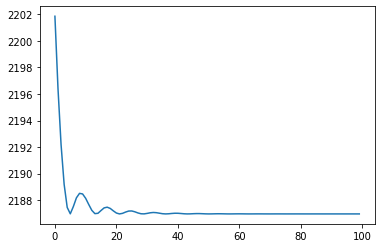

In [7]:
# plot loss trace
plt.plot(lp.loss_trace)

In [8]:
# fit a beta mixture recalibrated linear pool with K=1 mixture component
beta_mixt_rclp_K1 = BetaMixtureRCLP(M=2, K=1)
beta_mixt_rclp_K1.fit(component_log_prob=component_log_prob, component_log_cdf=component_log_cdf,
              optim_method="adam", num_iter=100, learning_rate=0.1)

# estimated ensemble parameters
beta_mixt_rclp_K1.parameters

{'rc_pi': <TransformedVariable: name=rc_pi, dtype=float32, shape=[1], fn="softmax_centered", numpy=array([1.], dtype=float32)>,
 'rc_alpha': <TransformedVariable: name=rc_alpha, dtype=float32, shape=[1], fn="softplus", numpy=array([0.87363976], dtype=float32)>,
 'rc_beta': <TransformedVariable: name=rc_beta, dtype=float32, shape=[1], fn="softplus", numpy=array([0.40509564], dtype=float32)>,
 'lp_w': <TransformedVariable: name=lp_w, dtype=float32, shape=[2], fn="softmax_centered", numpy=array([0.9429581 , 0.05704189], dtype=float32)>}

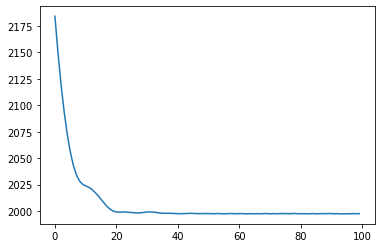

In [9]:
# plot loss trace
plt.plot(beta_mixt_rclp_K1.loss_trace)

In [10]:
# fit a beta mixture recalibrated linear pool with K=10 mixture components
# note: we increased `num_iter` to 2000 after observing that estimation had
# not reached convergence with `num_iter = 100`
beta_mixt_rclp_K10 = BetaMixtureRCLP(M=2, K=10)
beta_mixt_rclp_K10.fit(component_log_prob=component_log_prob, component_log_cdf=component_log_cdf,
              optim_method="adam", num_iter=2000, learning_rate=0.1)

# estimated ensemble parameters
beta_mixt_rclp_K10.parameters

{'rc_pi': <TransformedVariable: name=rc_pi, dtype=float32, shape=[10], fn="softmax_centered", numpy=
 array([3.4560697e-04, 1.1414887e-01, 1.3426779e-02, 1.3494744e-03,
        9.0944543e-02, 2.2453400e-01, 1.7405885e-03, 1.3221976e-02,
        5.2503610e-01, 1.5251964e-02], dtype=float32)>,
 'rc_alpha': <TransformedVariable: name=rc_alpha, dtype=float32, shape=[10], fn="softplus", numpy=
 array([1.6607642 , 5.5507984 , 4.2195964 , 0.92658913, 4.408662  ,
        1.9503714 , 0.95986795, 4.0234213 , 3.9246094 , 1.1014969 ],
       dtype=float32)>,
 'rc_beta': <TransformedVariable: name=rc_beta, dtype=float32, shape=[10], fn="softplus", numpy=
 array([ 8.474177  ,  0.28848335,  0.28855264,  0.2889795 ,  2.7363446 ,
        50.745102  ,  0.2890117 ,  0.2885776 ,  9.91976   ,  0.28918874],
       dtype=float32)>,
 'lp_w': <TransformedVariable: name=lp_w, dtype=float32, shape=[2], fn="softmax_centered", numpy=array([0.18551317, 0.8144868 ], dtype=float32)>}

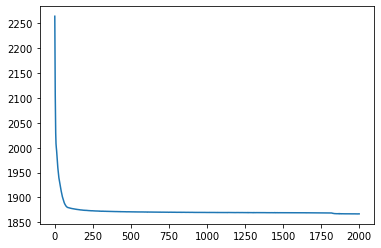

In [11]:
# plot loss trace
plt.plot(beta_mixt_rclp_K10.loss_trace)

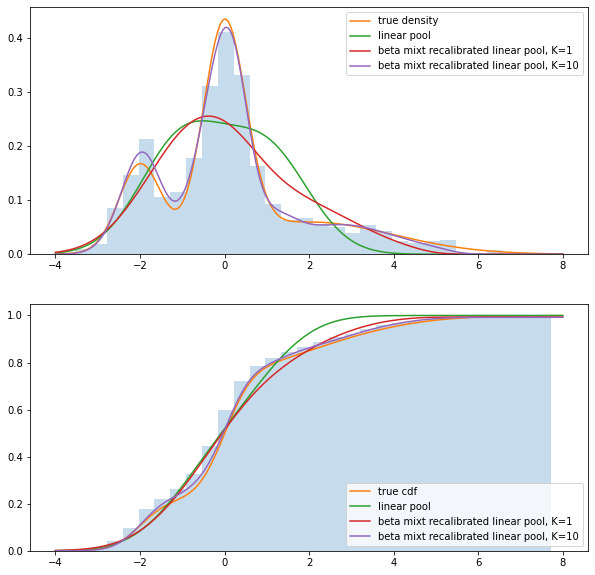

In [12]:
# calculate and plot densities from the linear pool
# and the beta recalibrated linear pool
y_grid_log_f = np.stack([norm.logpdf(y_grid, loc=component_mu[i], scale=component_sigma[i]) for i in range(2)], axis=1)
y_grid_log_F = np.stack([norm.logcdf(y_grid, loc=component_mu[i], scale=component_sigma[i]) for i in range(2)], axis=1)

lp_prob = lp.prob(y_grid_log_f, y_grid_log_F)
beta_mixt_rclp_K1_prob = beta_mixt_rclp_K1.prob(y_grid_log_f, y_grid_log_F)
beta_mixt_rclp_K10_prob = beta_mixt_rclp_K10.prob(y_grid_log_f, y_grid_log_F)

lp_cdf = lp.cdf(y_grid_log_F)
beta_mixt_rclp_K1_cdf = beta_mixt_rclp_K1.cdf(y_grid_log_F)
beta_mixt_rclp_K10_cdf = beta_mixt_rclp_K10.cdf(y_grid_log_F)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].hist(y, bins=30, density=True, histtype='stepfilled', alpha=0.25)
ax[0].plot(y_grid, f, label='true density')
ax[0].plot(y_grid, lp_prob, label='linear pool')
ax[0].plot(y_grid, beta_mixt_rclp_K1_prob, label='beta mixt recalibrated linear pool, K=1')
ax[0].plot(y_grid, beta_mixt_rclp_K10_prob, label='beta mixt recalibrated linear pool, K=10')
ax[0].legend()

ax[1].hist(y, bins=30, density=True, cumulative=True, histtype='stepfilled', alpha=0.25)
ax[1].plot(y_grid, F, label='true cdf')
ax[1].plot(y_grid, lp_cdf, label='linear pool')
ax[1].plot(y_grid, beta_mixt_rclp_K1_cdf, label='beta mixt recalibrated linear pool, K=1')
ax[1].plot(y_grid, beta_mixt_rclp_K10_cdf, label='beta mixt recalibrated linear pool, K=10')
ax[1].legend()

plt.show()